In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gdf = gpd.read_file("States shapefile/States_shapefile.shp")
gdf.drop(columns=["FID", "Program", "Flowing_St", "FID_1"], inplace=True)
gdf.head()

,State_Code,State_Name,geometry
0,AL,ALABAMA,"POLYGON ((-9469956.551 3760777.874, -9474975.1..."
1,AK,ALASKA,"MULTIPOLYGON (((-17959594.808 8122953.579, -17..."
2,AZ,ARIZONA,"POLYGON ((-12748377.957 3898982.239, -12752659..."
3,AR,ARKANSAS,"POLYGON ((-10515427.391 4055253.485, -10514418..."
4,CA,CALIFORNIA,"MULTIPOLYGON (((-13543710.331 4603367.825, -13..."


In [3]:
gdf2 = gpd.read_file("Districts shapefile\congress.shp")
gdf2.drop(columns=["congress", "fips", "name"], inplace=True)
gdf2.head()

,id,geometry
0,WA01,"POLYGON ((-122.09655 47.60231, -122.13244 47.6..."
1,WA10,"MULTIPOLYGON (((-122.22951 47.25756, -122.2188..."
2,WA02,"MULTIPOLYGON (((-122.20153 48.18791, -122.2031..."
3,WA03,"POLYGON ((-123.16053 46.83748, -123.12864 46.8..."
4,WA04,"POLYGON ((-120.70208 48.53159, -120.68853 48.5..."


In [4]:
def view_state(state:str):
    gdf2[gdf2["id"].str.contains(state)].plot(figsize=(10,10), edgecolor="black", color="lightgreen")
    plt.show()

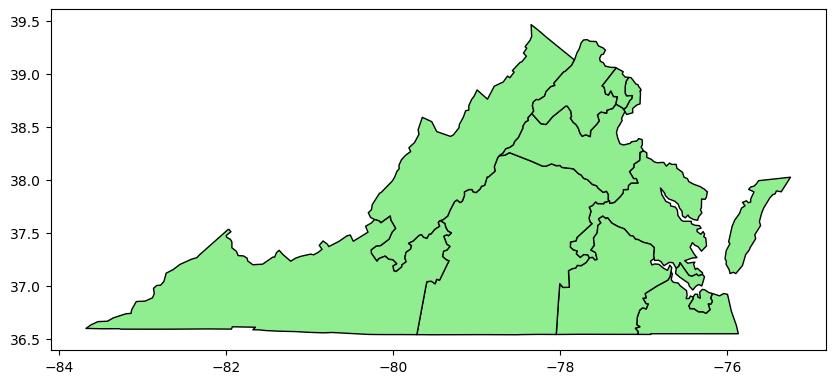

In [5]:
view_state("VA")

In [6]:
df = pd.read_csv("1976-2020-president.csv")

In [7]:
df.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified
0,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"CARTER, JIMMY",DEMOCRAT,False,659170,1182850,20210113,NaN,DEMOCRAT
1,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"FORD, GERALD",REPUBLICAN,False,504070,1182850,20210113,NaN,REPUBLICAN
2,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"MADDOX, LESTER",AMERICAN INDEPENDENT PARTY,False,9198,1182850,20210113,NaN,OTHER
3,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"BUBAR, BENJAMIN """"BEN""""",PROHIBITION,False,6669,1182850,20210113,NaN,OTHER
4,1976,ALABAMA,AL,1,63,41,US PRESIDENT,"HALL, GUS",COMMUNIST PARTY USE,False,1954,1182850,20210113,NaN,OTHER


In [8]:
def plot_results(year, df):
    idx = df[df["year"] == year].groupby("state")["candidatevotes"].idxmax()
    max_scores = df.loc[idx]
    res = pd.merge(gdf, max_scores, left_on="State_Name", right_on="state")
    ax = res[res["party_simplified"] == "DEMOCRAT"].plot(figsize=(10,10), edgecolor="none", color="blue")
    res[res["party_simplified"] == "REPUBLICAN"].plot(figsize=(10,10), edgecolor="none", color="red", ax=ax)
    plt.show()
    return res

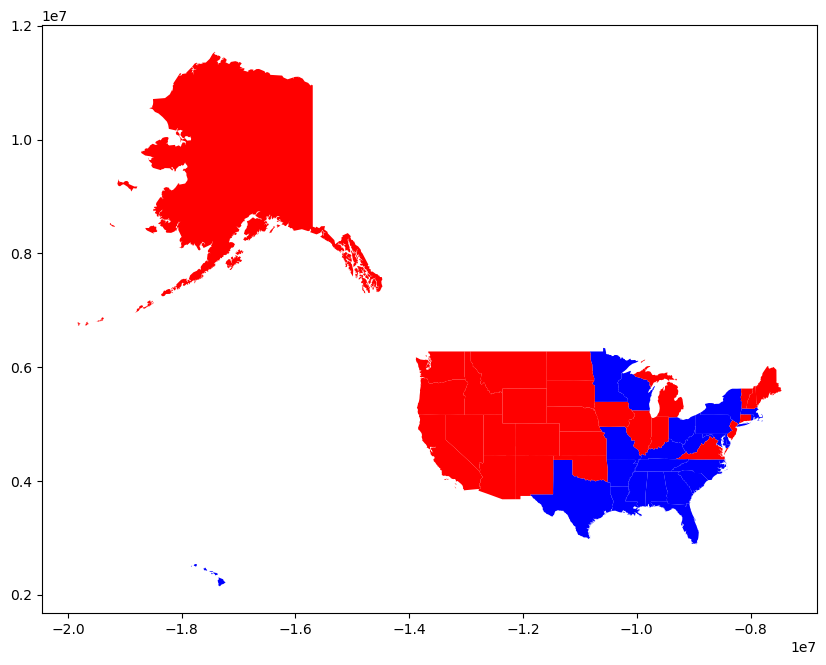

In [12]:
res = plot_results(1976, df)

In [13]:
sdf = pd.read_csv("1976-2020-senate.csv", encoding='unicode_escape')

In [67]:
polls = pd.read_csv("president_polls.csv")

In [68]:
from datetime import datetime, timedelta
bdd = datetime(year=2024, month=7, day=21)

In [69]:
polls["state"] = polls["state"].fillna("National")

In [70]:
polls["created_at"] = pd.to_datetime(polls["created_at"])

C:\Users\matth\AppData\Local\Temp\ipykernel_4916\1684343794.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  polls["created_at"] = pd.to_datetime(polls["created_at"])


In [71]:
idx = polls[(polls["state"] == "California") & (polls["created_at"] > bdd)].groupby("poll_id")["pct"].idxmax()
polls.loc[idx][["pollster","answer", "pct", "created_at"]]

,pollster,answer,pct,created_at
2193,Capitol Weekly,Harris,54.0,2024-07-29 20:21:00
1677,Capitol Weekly,Harris,54.0,2024-07-29 20:22:00
1300,Capitol Weekly,Harris,59.0,2024-07-30 15:54:00
725,UC Berkeley,Harris,59.0,2024-08-14 10:55:00
211,ActiVote,Harris,65.3,2024-08-19 15:30:00
414,Capitol Weekly,Harris,57.0,2024-08-25 13:18:00


In [72]:
harris_polls = polls.loc[polls[polls["answer"] == "Harris"].index]["question_id"]
trump_polls = polls.loc[polls[polls["answer"] == "Trump"].index]["question_id"]

In [73]:
trump_harris_polls = polls[(polls["question_id"].isin(harris_polls)) & (polls["question_id"].isin(trump_polls)) & (polls["created_at"] > bdd)]

In [74]:
trump_harris_polls["state"]

0       North Carolina
1       North Carolina
2             National
3             National
4             National
             ...      
2286      Pennsylvania
2337           Arizona
2338           Arizona
2351         Wisconsin
2352         Wisconsin
Name: state, Length: 1678, dtype: object

In [75]:
pivot = pd.pivot_table(trump_harris_polls, values="pct", columns=["answer"], index=["question_id", "pollster", "state", "created_at"])

In [76]:
pivot["winner"] = pivot.idxmax(axis=1)

In [77]:
pivot["margin"] = np.abs(pivot["Harris"] - pivot["Trump"])

In [78]:
pivot.reset_index(inplace=True)

In [79]:
pivot["days_old"] = (datetime.now() - pivot["created_at"]).dt.days

In [80]:
pivot["time_weight"] = 0.95 ** pivot["days_old"]

In [81]:
def get_state_averages(state):
    state_df = pivot[pivot["state"] == state]
    total_weight = state_df["time_weight"].sum()
    harris = (state_df["Harris"] * state_df["time_weight"]).sum() / total_weight
    trump = (state_df["Trump"] * state_df["time_weight"]).sum() / total_weight
    print(f"{state}\nHarris: {harris:.2f}\nTrump:  {trump:.2f}")

In [82]:
for state in pivot["state"].unique():
    get_state_averages(state)
    print()

New Hampshire
Harris: 50.28
Trump:  44.40

Georgia
Harris: 45.56
Trump:  47.97

National
Harris: 46.98
Trump:  44.70

Arizona
Harris: 45.17
Trump:  45.55

Michigan
Harris: 46.99
Trump:  44.55

Pennsylvania
Harris: 47.11
Trump:  46.43

Wisconsin
Harris: 48.05
Trump:  45.08

North Carolina
Harris: 46.28
Trump:  46.24

Maine
Harris: 55.40
Trump:  40.10

Florida
Harris: 44.54
Trump:  49.14

Minnesota
Harris: 47.37
Trump:  41.06

Nevada
Harris: 45.78
Trump:  44.49

Washington
Harris: 46.78
Trump:  39.49

California
Harris: 59.04
Trump:  35.24

Oregon
Harris: 47.00
Trump:  42.00

Ohio
Harris: 42.46
Trump:  53.69

New York
Harris: 54.88
Trump:  39.97

New Mexico
Harris: 49.81
Trump:  41.86

Montana
Harris: 39.38
Trump:  54.90

Maine CD-1
Harris: 61.12
Trump:  35.66

Maine CD-2
Harris: 48.26
Trump:  46.30

Texas
Harris: 43.95
Trump:  48.57

Nebraska CD-2
Harris: 48.38
Trump:  42.00

Virginia
Harris: 46.99
Trump:  44.07

Vermont
Harris: 68.50
Trump:  28.00

Utah
Harris: 26.50
Trump:  55.50

Mis

In [74]:
pivot["state"].unique()

array(['Florida', 'New Hampshire', 'Texas', 'Arizona', 'Georgia',
       'Michigan', 'Nevada', 'Pennsylvania', 'Wisconsin', 'California',
       'North Carolina', 'Ohio', 'Virginia', 'Washington', 'New York',
       'Maine', 'Minnesota', 'Oregon', 'New Mexico', 'Montana',
       'Maine CD-1', 'Maine CD-2', 'Nebraska CD-2'], dtype=object)

In [77]:
pivot[pivot["state"] == ""]

answer,question_id,pollster,state,created_at,De la Cruz,Harris,Kennedy,Oliver,Stein,Terry,Trump,West,winner,margin,days_old,time_weight


In [80]:
polls[polls["state"].isnull()]

4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
        ... 
12329    NaN
12330    NaN
12331    NaN
12332    NaN
12333    NaN
Name: state, Length: 6537, dtype: object